# Guide to Simple Blockchain Analysis using Dogecoin.info API


The aim of this article to show how easy it is with a little bit of python to analyse the dogecoin blockchain and hopefully learn something in the process. The [dogecoin.info](dogecoin.info) API allows for easy access to dogecoin blockchain data. In this post I will have quick look at submitting requests and analysing the returned data.

## Setup

As with all python data science endeavours, first we have to import all libraries we will be using.

In [303]:
import datetime
import io
import json
import pprint
from typing import Union

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

## Request Block Information From Doge Coin

To send a request to [dogecoin.info](dogecoin.info) I am using the python [requests](https://requests.readthedocs.io/en/master/) library. The `get_block` function below allows us to send a simple https request to get information about an individual block by just specifying the block height. To find the current height we can use `get_current_height`, which is just a simple http request.

In [25]:
def get_current_height() -> Union[int, None]:
    url = "http://dogechain.info/chain/Dogecoin/q/getblockcount"
    with requests.get(url) as r:
        if r.ok:
            return int(r.content)
        
def get_block(height: int) -> Union[dict, None]:
    url = f"https://dogechain.info/api/v1/block/{height}"
    with requests.get(url) as r:
        if r.ok:
            return json.loads(r.content) 

Using these functions we can get the current height and retrieve the data for a given block.

In [27]:
current_height = get_current_height()
print(f"Current dogecoin height: {current_height:,}")
pprint.pprint(get_block(current_height))

Current dogecoin height: 3,641,435
{'block': {'average_coin_age': '395.32024690',
           'confirmations': 1,
           'difficulty': 5357404.901646454,
           'hash': '32bce595d10cbea0d7a897c38f9c0a8629df24524aead7478e799c9ea05646e2',
           'height': 3641435,
           'is_orphan': False,
           'merkleroot': '5d07643de6e1784ed5a2ba1169a9b8761116bd12b8f8f59bb5d494c9fccb2083',
           'next_block_hash': None,
           'nonce': 0,
           'num_txs': 14,
           'previous_block_hash': '0182961c8c22b153f659936e7c34432031410d45a7e1266e07217a9fe6688eeb',
           'time': 1615460006,
           'txs': ['eae8fe99edf143b2564b750add70eca6d07381f38a75a1c226a4be1117cdd4a7',
                   '8f17d5e66025a6331310076d5d8f217b6e52a7aa12f7ea5b5735816fc2097b90',
                   '67922ff4f84a4cfabf526bf0009e2b06d67cf0427971e351e2e9969cfd1c4e29',
                   '5d6338526282f741b340fd59964101e9be3d9378bd97ad5ed46cc4c30e6d94b8',
                   'f4503911cb02335e

There is a lot of data in each block. It is worth noting the data is nested in the json object under the `block` key.

## Sampling Blocks

Dogecoin roughly adds a block every minute and to query for every block would take a long time, so I am going to sample by requesting every 10,000th block. To get all the relevant block I just loop over the block heights and store the results in a dictionary.

In [79]:
sample_every_n_blocks = int(1e4)
sample_block_heights = range(0, current_height, sample_every_n_blocks)
sample_blocks = {height: get_block(height) for height in sample_block_heights}

### Convert to Pandas
To further analyse the data I convert the json objects to a pandas dataframe. First I remove any empty responses. Then as I mentioned earlier the actual block data is nested into the json object under the key `block`. These block data are then passed to pandas as a list of dictionaries. 

In [309]:
df = pd.DataFrame.from_records([block.get('block') for block in sample_blocks.values() if block])

In [310]:
print(list(df.columns))

['hash', 'height', 'previous_block_hash', 'next_block_hash', 'is_orphan', 'difficulty', 'time', 'confirmations', 'merkleroot', 'num_txs', 'value_in', 'value_out', 'version', 'average_coin_age', 'nonce', 'txs']


All the fields are present in the dataframe, but for now I am only going to focus on a few.

In [311]:
df = df[['height', 'num_txs', 'value_in', 'value_out', 'average_coin_age', 'time', 'difficulty']]
df.tail()

,height,num_txs,value_in,value_out,average_coin_age,time,difficulty
311,3600000,18,114339200.41422897,114349200.41422897,36435.70283672,1612832557,4.274597e+06
312,3610000,12,45203.74831678,55203.74831678,13037.94633612,1613465378,3.299210e+06
313,3620000,48,33368451.83452779,33378451.83452779,5677.22348323,1614100471,5.218543e+06
314,3630000,11,114010.06889251,124010.06889251,3380.10823632,1614734211,3.303403e+06
315,3640000,27,31908230.88046244,31918230.88046244,724.15508729,1615368753,4.471873e+06


### Handling Time

The creation time of each block is in the `time` column as a timestamp. This can easily be converted to a python datetime. Given the time between blocks is around 7 days, I have just rounded to the nearest date to simplify further analysis.

In [312]:
df.loc[:,'time'] = pd.to_datetime(df.loc[:,'time'], unit='s').dt.round('1D')
df = df.set_index('time')

In [313]:
df.tail()

,height,num_txs,value_in,value_out,average_coin_age,difficulty
time,,,,,,
2021-02-09,3600000,18,114339200.41422897,114349200.41422897,36435.70283672,4.274597e+06
2021-02-16,3610000,12,45203.74831678,55203.74831678,13037.94633612,3.299210e+06
2021-02-24,3620000,48,33368451.83452779,33378451.83452779,5677.22348323,5.218543e+06
2021-03-03,3630000,11,114010.06889251,124010.06889251,3380.10823632,3.303403e+06
2021-03-10,3640000,27,31908230.88046244,31918230.88046244,724.15508729,4.471873e+06


### Price Data
As part of most blockchain analysis we probably want to include the value of doge against the US dollar. There are many APIs and websites that provide price data but for simplicity I use [yahoo finance](https://finance.yahoo.com/quote/DOGE-USD/). By simply specifying the currency pair (in this case DOGE/USD) and the start and stop times you can get the open, high, low and close prices trivially.

By using the requests library again we can get pull the prices. By using the min and max times of our blockchain data we can request the relevant timespan from yahoo as well. The yahoo finance data is returned as bytes and we can use `io.BytesIO` to push the data into pandas.

In [314]:
def get_doge_price_data(start_timestamp: int, end_timestamp: int) -> Union[bytes, None]:
    
    url = f"https://query1.finance.yahoo.com/v7/finance/download/DOGE-USD?period1={start_timestamp}&period2={end_timestamp}&interval=1d&events=history"
    with requests.get(url) as r:
        if r.ok:
            return r.content

In [315]:
price_data = get_doge_price_data(int(df.index.min().timestamp()), int(df.index.max().timestamp()))
df_price = pd.read_csv(io.BytesIO(price_data), parse_dates=['Date'])
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0
1,2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0
2,2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0
3,2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0
4,2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0


### Joining Price Data and Blockchain Data

We now have two dataframes: one of blockchain data and one of prices, but it would be better if we could combine them. Given they both contain a date column we can use this for the joining.

In [316]:
df = pd.merge(df, df_price[['Date','Close']], left_index=True, right_on='Date')
df.set_index('Date', inplace=True)

In [317]:
df.tail()

,height,num_txs,value_in,value_out,average_coin_age,difficulty,Close
Date,,,,,,,
2021-02-09,3600000,18,114339200.41422897,114349200.41422897,36435.70283672,4.274597e+06,0.070070
2021-02-16,3610000,12,45203.74831678,55203.74831678,13037.94633612,3.299210e+06,0.053520
2021-02-24,3620000,48,33368451.83452779,33378451.83452779,5677.22348323,5.218543e+06,0.056555
2021-03-03,3630000,11,114010.06889251,124010.06889251,3380.10823632,3.303403e+06,0.050592
2021-03-10,3640000,27,31908230.88046244,31918230.88046244,724.15508729,4.471873e+06,0.056004


### Correlations

Now we have a rather our dataframe will all the data of interest lets have a quick look at correlations between columns. For this I am using pandas `corr()` functionality and the seaborn heatmap. Before the correlation a few of the columns need to be converted to a numeric data type. This goes back to the format of the json returned by dogecoin.info as some of the numeric values are returned as strings.

In [321]:
df['value_in'] = pd.to_numeric(df['value_in'])
df['value_out'] = pd.to_numeric(df['value_out'])
df['average_coin_age'] = pd.to_numeric(df['average_coin_age'])

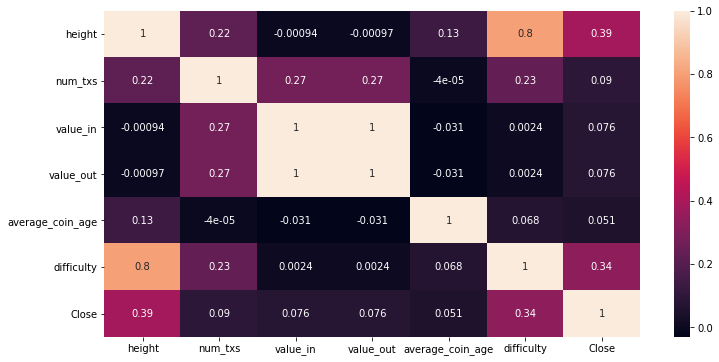

In [319]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, ax=ax);

Unsurprisingly the value_in and value_out are perfectly correlated. Aside from this the strongest correlation found is between blockchain height and difficulty.

### Time Series

Lets have a look at how difficulty varies over time. Above we used height, but given the near-constant rate of block creations we can switch to time and in the process get a more interpretable feature.

Below we have made of pandas and matplotlib to visualise the DOGE/USD price and the difficulty. To smooth out the spikes we have used the `rolling` pandas method to calculate a rolling mean. As doge spent most of its initial life at a very low price and in the last couple of years has jumped significantly we have a very wide range of values to represent. To achieve we have a log y-scale.

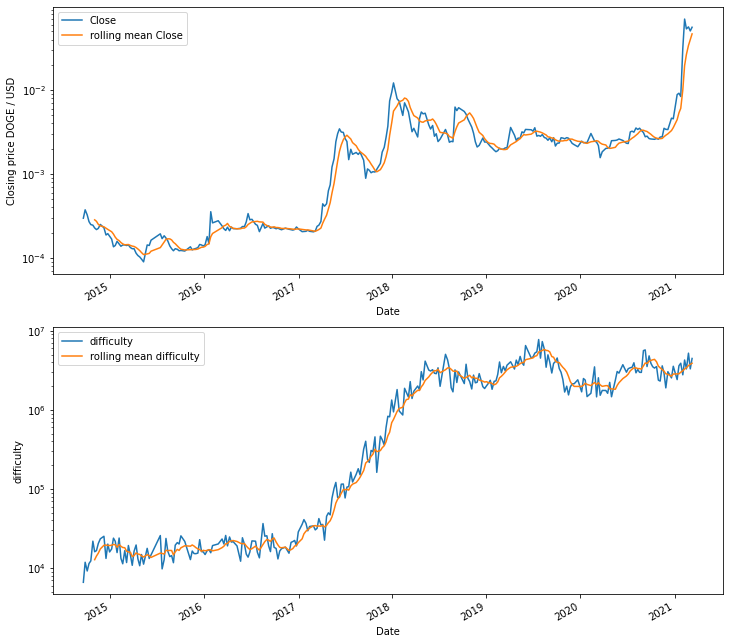

In [341]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,12), nrows=2)

df['Close'].plot(ax=ax1, label='Close')
df['Close'].rolling(7).mean().plot(ax=ax1, label='rolling mean Close')
ax1.set_ylabel('Closing price DOGE / USD')
ax1.set_yscale('log')
ax1.legend()

df['difficulty'].plot(ax=ax2, label='difficulty')
df['difficulty'].rolling(7).mean().plot(ax=ax2, label='rolling mean difficulty')
ax2.set_ylabel('difficulty')
ax2.set_yscale('log')
ax2.legend();

Both plots show initial low and rather flat values between 2015 and 2017. Then with a step-change in both. In the last few months we have another step-change in price, but have yet to see the same in difficulty. It would be interesting to recreate this plot in a couple of months to see if difficulty increases and whether miners have moved to doge.

## Conclusion

With just a little bit of python we have pulled blockchain data and price data from two APIs. We have then converted this raw data into something usable (pandas dataframe. Then using some simple visualisations maybe found out some new information about the dogecoin blockchain!

This article is available as a jupyter notebook on [github](https://github.com/blockchain-panda/dogecoin-analysis).